# >>> Title <<<

## Purpose

In [1]:
#Here we are importing the emissions data

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from datetime import date


sourceName = []   
state = []
oris = []
emissions = []  
opHours = []    
dateMonitor = []   
pageData = 0
maxPage = 0

while pageData <= maxPage:

    
    url = "https://rggi-coats.org/eats/rggi/index.cfm?hc=IiguXCAK"
    # >>> save sensitive information in to a git ignored file <<<
    with open('src_id.dat','r') as f:
        src_id = f.read()
        
    payload = {'fuseaction' : 'reportsV2.quarterly_emissions_rpt_output',
    'reporttype' : 'F',
    'FILTER_BEGINNING_YEAR' : '2009',
    'FILTER_ENDING_YEAR' : '2015',
    'FILTER_BEGINNING_QUARTER' : '1',
    'FILTER_ENDING_QUARTER' : '4',
    'SRC_NUMBER' : '',
    'SRC_NAME' : '',
    'REGION_ID' : '0',
    'page': pageData,
    'sourcesselected' : '',
    'returnfuseaction' : 'reportsv2.quarterly_emissions_rpt',
    'src_id' : src_id
    }

    #Request the data
    r = requests.post(url, payload)

    #save the data in a html
    with open("requests_results.html", "w") as f:

        f.write(r.content)

    #Open the data with beautiful
    plantData = BeautifulSoup(open('requests_results.html'))
    
    #Find how many pages there is
    maxPage = plantData.find_all('span', {'class': "fuse"})
    for tag in maxPage:
        maxPage = tag.find_all('b')
        for tag in maxPage:
            maxPage = tag.get_text()
    maxPage = float(maxPage[-8:-4]) // 100
    
    
    #Clean html
    plantData = plantData.find_all('tr', {'valign': "baseline"})

    lineData= 0
    for tag in plantData:
        plantData[lineData] = tag.find_all('td')
    
        columnData = 0
        for tag in plantData[lineData]:
            plantData[lineData][columnData] = tag.get_text().encode('ascii', 'ignore')
            columnData = columnData +1
    
        lineData = lineData +1


    #Organize the data
    for i in range (0,len(plantData)):
    
        #Emissions which we also transform to float
        if plantData[i][-4] == 'Not Operating' or plantData[i][-4] == 'No Data':
            emissions.append(0)
        else:
            emissions.append(float(plantData[i][-4].replace(",", "")))

        #opHours which we also transform to float
        if plantData[i][-6] == 'Not Operating' or plantData[i][-6] == 'No Data':
            opHours.append(0)
        else:
            opHours.append(float(plantData[i][-6].replace(",", "")))

        #dateMonitor which we also transform to date using year and quarter
        dateMonitor.append(date(int(plantData[i][0]),(int(plantData[i][1])-1)*3+1,1))

        #sourceName 
        sourceName.append(plantData[i][2])
        
        #state 
        state.append(plantData[i][5])
        
        #oris 
        oris.append(plantData[i][3])

 
    pageData = pageData + 1
            

plantSummary = pd.DataFrame({'Plant_Name': sourceName,
                            'Operating_Hours': opHours,
                            'State': state,
                             'Oris': oris,
                            'Emissions': emissions,
                            'Date_Monitor': dateMonitor})


plantSummary.head()


,Date_Monitor,Emissions,Operating_Hours,Oris,Plant_Name,State
0,2009-01-01,2574.935,89.10,544,Devon,CT
1,2009-04-01,589.222,24.69,544,Devon,CT
2,2009-07-01,1156.144,48.24,544,Devon,CT
3,2009-10-01,4496.612,158.34,544,Devon,CT
4,2010-01-01,2445.324,87.80,544,Devon,CT


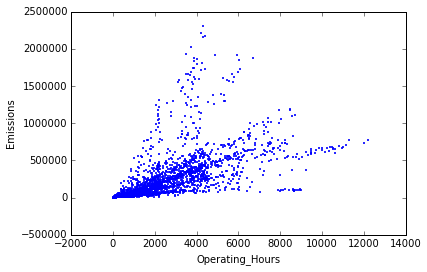

In [14]:
#Here we are doing a graph to start vizualising the data

import matplotlib.pyplot as plt
%matplotlib inline  
plantSummary.plot(kind = 'scatter', x = 'Operating_Hours', y = 'Emissions', s=1, color='blue')

## >>> what we learn from this table <<<

In [3]:
plantSummary.groupby(plantSummary.State).sum().sort('Emissions',ascending=False)

,Emissions,Operating_Hours
State,,
NY,2.229665e+08,2965151.21
MD,1.512589e+08,759258.86
MA,9.607211e+07,848833.77
NJ (First Control Period Only),5.315729e+07,643226.59
CT,4.316031e+07,473015.45
NH,3.399438e+07,299951.68
DE,2.610292e+07,333965.39
RI,2.063195e+07,274978.84
ME,1.955019e+07,283177.66


In [4]:
#Here we are importing the owner data

stateAll = [2,4,5,6,7,8,9,11,12]
sourceNameOwner = []
orisOwner = []
ownerName = []
    
for state in stateAll:
    
    url = "https://rggi-coats.org/eats/rggi/index.cfm?hc=ISggICAK"

    payload = {'fuseaction' : 'reportsv2.owners_rpt',
    'expandFilter' : '1',
    'setFilter' : 'true',
    'PROG_ID' : state,
    }

    #Request the data
    r = requests.post(url, payload)

    #save the data in a html
    with open("owner_results.html", "w") as f:

        f.write(r.content)

    #Open the data with beautiful
    ownerData = BeautifulSoup(open('owner_results.html'))
    
    #Clean html
    ownerData = ownerData.find_all('tr', {'valign': "baseline"})

    lineData= 0
    for tag in ownerData:
        ownerData[lineData] = tag.find_all('td')
    
        columnData = 0
        for tag in ownerData[lineData]:
            ownerData[lineData][columnData] = tag.get_text().encode('ascii', 'ignore')
            columnData = columnData +1
    
        lineData = lineData +1

    
    #Organize the data
    for i in range (0,len(ownerData)):
    
        #sourceName 
        sourceNameOwner.append(ownerData[i][0])
        
        #Oris code
        orisOwner.append(ownerData[i][2])

        #Owner
        ownerName.append(ownerData[i][4])
        
ownerSummary = pd.DataFrame({'Source_Name_Owner': sourceNameOwner,
                            'Oris_Code_Owner': orisOwner,
                            'Name_Owner': ownerName,
                             })


ownerSummary.head()



,Name_Owner,Oris_Code_Owner,Source_Name_Owner
0,New York Power Authority (Owner-Operator),7910,23rd and 3rd
1,"AG Energy, LP (Owner-Operator)",10803,AG - Energy
2,Allegany Generating Station (Owner-Operator),10619,Allegany Station No. 133
3,"NRG Arthur Kill Operations, Inc. (Operator)\rA...",2490,Arthur Kill
4,"Astoria Energy, LLC (Owner)\rGDF Suez Energy, ...",55375,Astoria Energy


## >>> what we learn from this table <<<

In [5]:
#Here we are merging the two last tables and droping some columns

owner_Emission_Summary = pd.merge(plantSummary, ownerSummary, how='inner', 
               left_on='Oris', right_on='Oris_Code_Owner')
owner_Emission_Summary = owner_Emission_Summary.drop(['Source_Name_Owner','Oris_Code_Owner'], axis=1) 

In [6]:
#The data looks clean!
owner_Emission_Summary.head()

,Date_Monitor,Emissions,Operating_Hours,Oris,Plant_Name,State,Name_Owner
0,2009-01-01,2574.935,89.10,544,Devon,CT,"NRG Devon Operations, Inc. (Operator)\rDevon P..."
1,2009-04-01,589.222,24.69,544,Devon,CT,"NRG Devon Operations, Inc. (Operator)\rDevon P..."
2,2009-07-01,1156.144,48.24,544,Devon,CT,"NRG Devon Operations, Inc. (Operator)\rDevon P..."
3,2009-10-01,4496.612,158.34,544,Devon,CT,"NRG Devon Operations, Inc. (Operator)\rDevon P..."
4,2010-01-01,2445.324,87.80,544,Devon,CT,"NRG Devon Operations, Inc. (Operator)\rDevon P..."


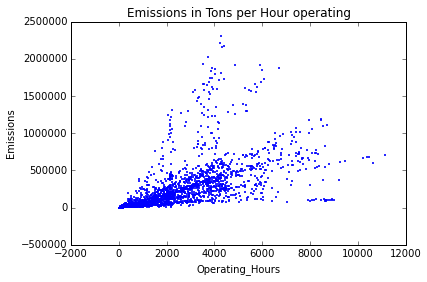

In [15]:
#Now we can do some more vizualisation to impress people :) wowwww

pd.options.display.float_format = '{:20,.2f}'.format
owner_Emission_Summary.plot(kind = 'scatter', x = 'Operating_Hours', y = 'Emissions', title="Emissions in Tons per Hour operating", s=1, color='blue')


## >>> what we learn from this figure <<<

In [37]:
#How did emissions evolve?
owner_Emission_Summary.groupby(['State',owner_Emission_Summary['Date_Monitor'].map(lambda x: x.year)])[['Emissions']].sum().unstack('State').plot(y = 'Emissions',xticks=['2009','2010','2011','2012','2013','2014','2015'])
plt.legend(loc=2)

TypeError: cannot perform reduce with flexible type

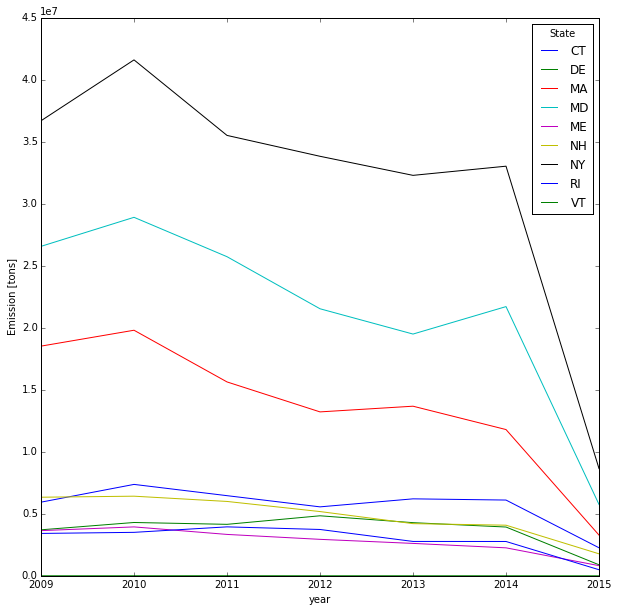

In [60]:
# >>> change of plotting <<<
owner_Emission_Summary['year'] = [x.year for x in owner_Emission_Summary.Date_Monitor]
data = owner_Emission_Summary.groupby(['State','year'])['Emissions'].sum().unstack('State')
ax = data.plot(figsize=(10,10))
ax.set_xticklabels(list(data.index))
plt.ylabel('Emission [tons]')
plt.show()

In [61]:
owner_Emission_Summary['Efficiency']=owner_Emission_Summary['Emissions']/owner_Emission_Summary['Operating_Hours']

In [67]:
owner_Emission_Summary.groupby([owner_Emission_Summary['Date_Monitor'].map(lambda x: x.year),'Plant_Name'])[[Emissions'.sum()]].sort('Emissions',ascending=False)

State  year
CT     2009           5,938,942.76
       2010           7,370,639.37
       2011           6,462,640.85
       2012           5,559,852.31
       2013           6,206,179.10
       2014           6,108,639.72
       2015           2,260,021.30
DE     2009           3,708,331.13
       2010           4,299,269.49
       2011           4,150,396.00
       2012           4,839,521.92
       2013           4,285,050.43
       2014           3,932,999.26
       2015             887,353.04
MA     2009          18,522,462.56
       2010          19,803,429.06
       2011          15,634,871.54
       2012          13,218,481.06
       2013          13,677,273.35
       2014          11,793,968.93
       2015           3,282,056.46
MD     2009          26,568,682.67
       2010          28,909,657.68
       2011          25,734,288.07
       2012          21,534,939.19
       2013          19,495,159.09
       2014          21,709,132.90
       2015           5,754,356.39
ME     2

In [73]:
data = owner_Emission_Summary.groupby(['year','Plant_Name'])['Emissions'].sum()
data.sort('Emissions',ascending=False)
print data.head()
print '---------'
print data.tail()

year  Plant_Name    
2010  Morgantown               7,969,125.45
2011  Morgantown               6,895,629.34
2009  Brayton Point            6,879,086.78
      Brandon Shores           6,860,722.39
2011  Brandon Shores           6,610,419.07
Name: Emissions, dtype: float64
---------
year  Plant_Name                 
2015  Massena Energy Facility                       0.00
2014  GMMM Westover                                 0.00
      Far Rockaway                                  0.00
2015  R. Paul Smith Power Station                   0.00
2012  GMMM Westover                                 0.00
Name: Emissions, dtype: float64


## >>> Conclusion <<<